# Introduction

This is a binary classification problem to predict company bankruptcy using data from the Taiwan Economic Journal for the years 1999–2009. The dataset is highly imbalanced, a common characteristic for default/bankruptcy prediction problems. All predictors in this dataset are numeric, primarily consisting of financial indicators from financial statements. There are no missing values in this dataset.

The dataset can be accessed here: https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction/data

The full dataset comprises 6,819 observations with 96 predictors, which poses a "Curse of Dimensionality" problem. Therefore, my goal is to develop a powerful model that distinguishes between events (bankruptcies) and non-events while ensuring a robust set of variables through a comprehensive variable selection process. I aim to achieve a model with an AUC-ROC greater than 90% on the test set using fewer than 10 final predictors. This approach adheres to the principle of "Parsimony" and avoids the "Curse of Dimensionality."

My Plan for Variable Selection:

1. Screening: Remove near-zero variance (NZV) and zero variance (ZV) predictors, and eliminate highly correlated variables to reduce redundancy.
2. Filtering Method: Use automatic Weight of Evidence (WoE) binning via Decision Trees and drop variables based on Information Value (IV).
3. Wrapper Method: Apply Recursive Feature Elimination (RFE) to perform an initial broad reduction of the feature set. RFE quickly eliminates a large number of irrelevant features based on their importance scores from an estimator.
4. Performance-Oriented Method: Use Backward Trimming (BART) to ensure that the final feature set is optimized for performance, potentially addressing any multicollinearity issues or feature interactions that RFE might not fully capture.

After the variable selection process, I will use a Random Forest classifier with hyperparameter tuning to train the model.

Futhermore, the Calibration step is applied. 


# 1. Import Data and Simple Manipulation

In [1]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV,RandomizedSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold, RFECV, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, f1_score, precision_recall_curve,precision_score,recall_score,brier_score_loss
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from optbinning import BinningProcess
from feature_engine.selection import SmartCorrelatedSelection, RecursiveFeatureElimination
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve


(CVXPY) Aug 03 09:03:02 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Aug 03 09:03:02 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
data = pd.read_csv('Bankruptcy_Prediction.csv')

In [3]:
data.head(5)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


All of the predictors are numeric.

In [4]:
numeric_count = len(data.select_dtypes(include=['number']).columns)
numeric_count

96

In [5]:
character_count = len(data.select_dtypes(include=['object', 'string']).columns)
character_count

0

In [6]:
data.columns[0:10]

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue'],
      dtype='object')

In [7]:
def clean_column_name(col_name):
    # Remove spaces and special characters, replace them with underscores
    col_name = re.sub(r'[^A-Za-z0-9]+', '_', col_name)
    # Remove leading and trailing underscores
    col_name = col_name.strip('_')
    return col_name


Clean the names of all columns to be in standard format

In [8]:
data.columns = [clean_column_name(col) for col in data.columns]
data.columns[0:5]

Index(['Bankrupt', 'ROA_C_before_interest_and_depreciation_before_interest',
       'ROA_A_before_interest_and_after_tax',
       'ROA_B_before_interest_and_depreciation_after_tax',
       'Operating_Gross_Margin'],
      dtype='object')

The dataset is highly imbalanced.

Bankrupt
0    6599
1     220
Name: count, dtype: int64

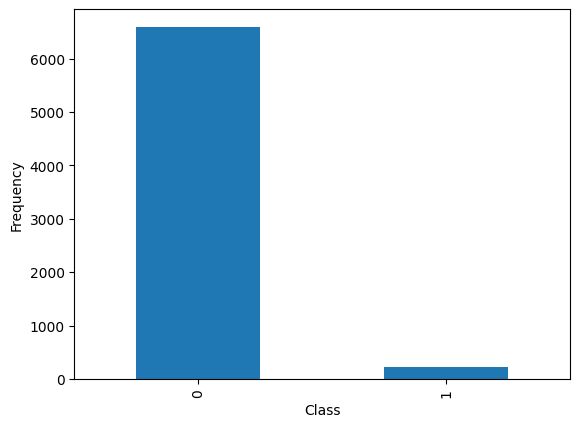

In [9]:
data['Bankrupt'].value_counts().plot.bar()
plt.xlabel('Class')
plt.ylabel('Frequency')
data['Bankrupt'].value_counts()

# 2. Data Preparation, Feature Engineering, Variable Selection

The target variable is 'Bankrupt' and should be converted to categorical

In [10]:
data['Bankrupt'] = data['Bankrupt'].astype('category')


There is no missing values in the dataset

In [11]:
missing_values_count = data.isnull().sum().sum()
print(missing_values_count)

0


Split the data into training and test sets before any preprocessing

In [12]:
X = data.drop(columns=['Bankrupt'])
y = data['Bankrupt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)

## 2.1 Preprocessing (ZV, Robust Scaler) 

### Define preprocessing steps. 
1. remove Zero Variance variables
2. use Robust Scaler to handle outliers
3. No need to impute missingness because there are no missing values

In [13]:
preprocessing = Pipeline([
    ('ZV', VarianceThreshold(threshold=0.000)), # Zero Variance
     ('robust_scaler', RobustScaler()), # Outlier Treatment
    #('imputer', IterativeImputer(max_iter=10, random_state=0))
])

Apply preprocessing steps to the training data

In [14]:
X_train_preprocessed = preprocessing.fit_transform(X_train)
df_X_train_preprocessed = pd.DataFrame(X_train_preprocessed,columns=preprocessing.get_feature_names_out())

## 2.2 Correlation

### Remove highly correlated variables 
They basically give the same info if they have Pearson Correlation > 90%


In [15]:
# set up the selector
tr = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.9,
    missing_values="raise",
    selection_method="model_performance",
    estimator=DecisionTreeClassifier(random_state=1),
    scoring='roc_auc',
    cv=5,
)

In [16]:
Xt = tr.fit_transform(df_X_train_preprocessed, y_train)

###### List of the variables that highly correlated to each other

In [17]:
tr.correlated_feature_sets_

[{'After_tax_Net_Profit_Growth_Rate', 'Regular_Net_Profit_Growth_Rate'},
 {'After_tax_net_Interest_Rate',
  'Continuous_interest_rate_after_tax',
  'Non_industry_income_and_expenditure_revenue',
  'Pre_tax_net_Interest_Rate'},
 {'Borrowing_dependency', 'Liability_to_Equity'},
 {'Cash_flow_rate', 'Operating_Funds_to_Liability'},
 {'Current_Liabilities_Equity', 'Current_Liability_to_Equity'},
 {'Current_Liabilities_Liability', 'Current_Liability_to_Liability'},
 {'Debt_ratio', 'Net_worth_Assets'},
 {'Gross_Profit_to_Sales',
  'Operating_Gross_Margin',
  'Realized_Sales_Gross_Margin'},
 {'Net_Income_to_Total_Assets',
  'ROA_A_before_interest_and_after_tax',
  'ROA_B_before_interest_and_depreciation_after_tax'},
 {'Net_Value_Per_Share_A', 'Net_Value_Per_Share_B', 'Net_Value_Per_Share_C'},
 {'Net_profit_before_tax_Paid_in_capital',
  'Per_Share_Net_profit_before_tax_Yuan',
  'Persistent_EPS_in_the_Last_Four_Seasons'},
 {'Operating_Profit_Per_Share_Yuan', 'Operating_profit_Paid_in_capital'},

###### List of the variables to drop after the process of remove high correlation

In [18]:
tr.features_to_drop_

['After_tax_Net_Profit_Growth_Rate',
 'After_tax_net_Interest_Rate',
 'Continuous_interest_rate_after_tax',
 'Non_industry_income_and_expenditure_revenue',
 'Borrowing_dependency',
 'Operating_Funds_to_Liability',
 'Current_Liabilities_Equity',
 'Current_Liabilities_Liability',
 'Debt_ratio',
 'Gross_Profit_to_Sales',
 'Operating_Gross_Margin',
 'Net_Income_to_Total_Assets',
 'ROA_B_before_interest_and_depreciation_after_tax',
 'Net_Value_Per_Share_B',
 'Net_Value_Per_Share_C',
 'Net_profit_before_tax_Paid_in_capital',
 'Per_Share_Net_profit_before_tax_Yuan',
 'Operating_Profit_Per_Share_Yuan',
 'Revenue_Per_Share_Yuan']

In [19]:
df_X_train_preprocessed_corr = df_X_train_preprocessed.drop(columns=tr.features_to_drop_)

###### After removing varialbles due to Zero-Variance and Highly Correlation, we reduce the number of features from 96 to 75.
###### The variables that are removed are repeated with other vairables in term of info or giving no useful info at all

In [20]:
df_X_train_preprocessed_corr.shape

(5114, 75)

###### Columns were removed due to Zero-Variance and Highly Correlation

In [21]:

set(X_train.columns) - set(df_X_train_preprocessed_corr.columns)

{'After_tax_Net_Profit_Growth_Rate',
 'After_tax_net_Interest_Rate',
 'Borrowing_dependency',
 'Continuous_interest_rate_after_tax',
 'Current_Liabilities_Equity',
 'Current_Liabilities_Liability',
 'Debt_ratio',
 'Gross_Profit_to_Sales',
 'Net_Income_Flag',
 'Net_Income_to_Total_Assets',
 'Net_Value_Per_Share_B',
 'Net_Value_Per_Share_C',
 'Net_profit_before_tax_Paid_in_capital',
 'Non_industry_income_and_expenditure_revenue',
 'Operating_Funds_to_Liability',
 'Operating_Gross_Margin',
 'Operating_Profit_Per_Share_Yuan',
 'Per_Share_Net_profit_before_tax_Yuan',
 'ROA_B_before_interest_and_depreciation_after_tax',
 'Revenue_Per_Share_Yuan'}

## 2.3 Filtering with Binning and Predictive Power

###### We move on to do the Feature Engineering step.
###### Applying Automatic Binning Process via Decision Tree.
###### After that, we remove variables based on Information Value (IV) aka Filtering Method in Variable Selection

In [22]:
selection_criteria = {
    "iv": {"strategy": "highest"}
}

In [23]:
variable_names = list(df_X_train_preprocessed_corr.columns)
len(variable_names)

75

In [24]:
binning_process = BinningProcess(variable_names=variable_names,
                                 selection_criteria=selection_criteria
                                 #,max_n_bins=6
                                )

In [25]:
binning_process.fit(df_X_train_preprocessed_corr, y_train)

BinningProcess(selection_criteria={'iv': {'strategy': 'highest'}},
               variable_names=['ROA_C_before_interest_and_depreciation_before_interest',
                               'ROA_A_before_interest_and_after_tax',
                               'Realized_Sales_Gross_Margin',
                               'Operating_Profit_Rate',
                               'Pre_tax_net_Interest_Rate',
                               'Operating_Expense_Rate',
                               'Research_and_development_expense_rate',
                               'Cash_flow_rate',
                               'Interest_b...
                               'Total_Asset_Growth_Rate',
                               'Net_Value_Growth_Rate',
                               'Total_Asset_Return_Growth_Rate_Ratio',
                               'Cash_Reinvestment', 'Current_Ratio',
                               'Quick_Ratio', 'Interest_Expense_Ratio',
                               'Total_debt_Total_net_worth', 'Net_worth_Assets',
                               'Long_term_fund_suitability_ratio_A',
                               'Contingent_liabilities_Net_worth',
                               'Operating_profit_Paid_in_capital',
                               'Inventory_and_accounts_receivable_Net_value', ...])

##### The output of binning process top give info on IV, number of Bins, GINI to remove some variables

In [26]:
summary = binning_process.summary()
# Convert the summary to a DataFrame
summary_df = pd.DataFrame(summary)
summary_df.selected = True
# Sort the DataFrame by IV in descending order
sorted_summary_df = summary_df.sort_values(by='iv', ascending=False)
sorted_summary_df.head(20)

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
50,Retained_Earnings_to_Total_Assets,numerical,OPTIMAL,True,7,2.980088,0.266497,0.745813,0.0
11,Persistent_EPS_in_the_Last_Four_Seasons,numerical,OPTIMAL,True,8,2.899285,0.275946,0.773302,0.0
23,Interest_Expense_Ratio,numerical,OPTIMAL,True,8,2.82633,0.279674,0.738828,0.0
73,Interest_Coverage_Ratio_Interest_expense_to_EBIT,numerical,OPTIMAL,True,8,2.719549,0.267754,0.733985,0.0
72,Degree_of_Financial_Leverage_DFL,numerical,OPTIMAL,True,7,2.701392,0.265805,0.729904,0.0
1,ROA_A_before_interest_and_after_tax,numerical,OPTIMAL,True,7,2.670315,0.24379,0.721406,0.0
0,ROA_C_before_interest_and_depreciation_before_...,numerical,OPTIMAL,True,9,2.669505,0.243436,0.72341,0.0
51,Total_income_Total_expense,numerical,OPTIMAL,True,8,2.422825,0.250688,0.739741,0.0
4,Pre_tax_net_Interest_Rate,numerical,OPTIMAL,True,8,2.346766,0.238496,0.724547,0.0
74,Equity_to_Liability,numerical,OPTIMAL,True,8,2.320075,0.246818,0.733913,0.0


#### Example of Weight-of-Evidence (WoE) output binning for "Retained_Earnings_to_Total_Assets"

In [27]:
optb = binning_process.get_binned_variable("Retained_Earnings_to_Total_Assets")
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, -1.67)",454,0.088776,366,88,0.193833,-1.975699,0.907595,0.097984
1,"[-1.67, -0.88)",387,0.075675,361,26,0.067183,-0.770214,0.065185,0.007952
2,"[-0.88, -0.45)",477,0.093273,452,25,0.052411,-0.506189,0.030464,0.003768
3,"[-0.45, -0.11)",886,0.173250,868,18,0.020316,0.474825,0.031480,0.003898
4,"[-0.11, 0.07)",567,0.110872,561,6,0.010582,1.136966,0.087538,0.010389
5,"[0.07, 0.17)",260,0.050841,259,1,0.003846,2.155833,0.099757,0.010506
6,"[0.17, inf)",2083,0.407313,2082,1,0.000480,4.240089,1.758070,0.132000
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,5114,1.000000,4949,165,0.032264,,2.980088,0.266497


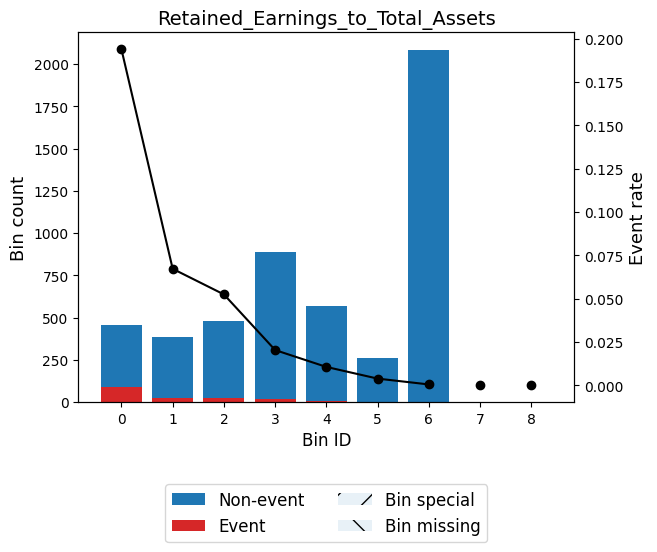

In [28]:
optb.binning_table.plot(metric="event_rate")

##### Filtering Variable Selection based on IV with threshold = 1.0

In [29]:
iv_threshold = 1.0
filtered_summary_df = sorted_summary_df[sorted_summary_df['iv'] > iv_threshold]

##### After this step, we can further reduce variables from 75 to 34 variables

In [30]:
selected_filter_IV = list(filtered_summary_df['name'])
len(selected_filter_IV)

34

In [31]:
df_X_train_preprocessed_WoE = binning_process.transform(df_X_train_preprocessed_corr, metric="woe")

In [32]:
df_X_train_preprocessed_WoE.shape

(5114, 75)

In [33]:
df_X_train_preprocessed_WoE = df_X_train_preprocessed_WoE[selected_filter_IV]

## 2.4 Wrapper Variable Selection using Recursive Feature Elimination (RFE)

In [34]:

rfe = RFECV(estimator=DecisionTreeClassifier(random_state=123),
              step=1,
              cv=5,
              scoring='roc_auc',
              min_features_to_select = 10
           )
df_X_train_preprocessed_WoE_RFE = rfe.fit_transform(df_X_train_preprocessed_WoE, y_train)

In [35]:
selected_features = df_X_train_preprocessed_WoE.columns[rfe.support_]
selected_features

Index(['Persistent_EPS_in_the_Last_Four_Seasons', 'Interest_Expense_Ratio',
       'Interest_Coverage_Ratio_Interest_expense_to_EBIT',
       'ROA_C_before_interest_and_depreciation_before_interest',
       'Total_income_Total_expense', 'Pre_tax_net_Interest_Rate',
       'Total_debt_Total_net_worth', 'Net_Value_Growth_Rate',
       'Net_Value_Per_Share_A', 'Quick_Ratio', 'Inventory_Working_Capital',
       'Quick_Assets_Current_Liability', 'Current_Liability_to_Current_Assets',
       'Operating_Profit_Rate', 'Working_capitcal_Turnover_Rate',
       'Working_Capital_Equity', 'Operating_profit_per_person',
       'Cash_Total_Assets', 'Cash_Flow_to_Liability',
       'Current_Liability_to_Assets', 'Cash_flow_rate'],
      dtype='object')

In [36]:
df_X_train_preprocessed_WoE_RFE = pd.DataFrame(df_X_train_preprocessed_WoE_RFE, columns=selected_features)
df_X_train_preprocessed_WoE_RFE.shape

(5114, 21)

##### After RFE, we can significant reduce variables to 21 variables

## 2.5 Backward Trimming Performance-based Selection (BART)

##### modified function to apply BART using Random Forest in Python

In [37]:
def backward_variable_selection(data, target_var, random_state=0):
    # Set seed for reproducibility
    np.random.seed(random_state)
    # Split data into test set (20%) and the remaining (80%)
    train_valid, test = train_test_split(data, test_size=0.2, stratify=data[target_var], random_state=random_state)
    # Split the remaining 80% into training (80% of 80%) and validation (20% of 80%)
    train, valid = train_test_split(train_valid, test_size=0.2, stratify=train_valid[target_var], random_state=random_state)
    # Backward variable selection based on AUC using Random Forest
    rf_model = RandomForestClassifier(random_state=random_state)
    rf_param = {
    'max_depth': np.arange(2, 16, 2),
    'n_estimators': np.arange(50, 500, 25),
    'min_samples_split' : [2, 5, 7, 10, 12],
    'min_samples_leaf' : [1, 3, 5, 7, 10] 
    }
    rf_model_CV = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param, 
                                        n_iter=20, scoring='roc_auc', cv=5,
                                        random_state=123, n_jobs = -2)
    
    rf_model_CV.fit(train.drop(columns=[target_var]), train[target_var])
    predictions = rf_model_CV.predict_proba(valid.drop(columns=[target_var]))[:, 1]
    
    AUC = roc_auc_score(valid[target_var], predictions)
    removed_predictors = []
    best_AUCs = [AUC]
    
    X_train_old = train.drop(columns=[target_var])
    y_train = train[target_var]
    X_valid_old = valid.drop(columns=[target_var])
    y_valid = valid[target_var]
    
    while X_train_old.shape[1] > 1:
        AUCs_temp_vec = []
        
        for j in range(X_train_old.shape[1]):
            X_train_new = X_train_old.drop(X_train_old.columns[j], axis=1)
            X_valid_new = X_valid_old[X_train_new.columns]  # Ensure the same columns are used in validation set
            
            rf_model.fit(X_train_new, y_train)
            predictions = rf_model.predict_proba(X_valid_new)[:, 1]
            AUC = roc_auc_score(y_valid, predictions)
            AUCs_temp_vec.append(AUC)
        best_index = np.argmax(AUCs_temp_vec)
        removed_predictors.append(X_train_old.columns[best_index])
        best_AUCs.append(AUCs_temp_vec[best_index])
        X_train_old = X_train_old.drop(X_train_old.columns[best_index], axis=1)
        X_valid_old = X_valid_old[X_train_old.columns]  # Ensure the validation set matches the train set

    remaining_predictors = X_train_old.columns.tolist()
    removed_predictors.extend(remaining_predictors)
    
    if len(remaining_predictors) > 0:
        rf_model.fit(X_train_old, y_train)
        X_valid_new = valid[remaining_predictors]
    else:
        rf_model = RandomForestClassifier(random_state=random_state)
        rf_model.fit(train[[target_var]], y_train)
        X_valid_new = valid[[target_var]]
    
    predictions = rf_model.predict_proba(X_valid_new)[:, 1]
    AUC = roc_auc_score(valid[target_var], predictions)
    best_AUCs.append(AUC)

    return removed_predictors, best_AUCs

In [38]:
combine_df_train_processed = pd.concat([df_X_train_preprocessed_WoE_RFE.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

In [39]:
combine_df_train_processed.columns

Index(['Persistent_EPS_in_the_Last_Four_Seasons', 'Interest_Expense_Ratio',
       'Interest_Coverage_Ratio_Interest_expense_to_EBIT',
       'ROA_C_before_interest_and_depreciation_before_interest',
       'Total_income_Total_expense', 'Pre_tax_net_Interest_Rate',
       'Total_debt_Total_net_worth', 'Net_Value_Growth_Rate',
       'Net_Value_Per_Share_A', 'Quick_Ratio', 'Inventory_Working_Capital',
       'Quick_Assets_Current_Liability', 'Current_Liability_to_Current_Assets',
       'Operating_Profit_Rate', 'Working_capitcal_Turnover_Rate',
       'Working_Capital_Equity', 'Operating_profit_per_person',
       'Cash_Total_Assets', 'Cash_Flow_to_Liability',
       'Current_Liability_to_Assets', 'Cash_flow_rate', 'Bankrupt'],
      dtype='object')

In [40]:
result = backward_variable_selection(combine_df_train_processed, "Bankrupt")
removed_predictors, best_AUCs = result

In [41]:
removed_predictors.append("NO_Vars_out")

##### The plot shows how the best AUC changes when a predictor is removed step-by-step

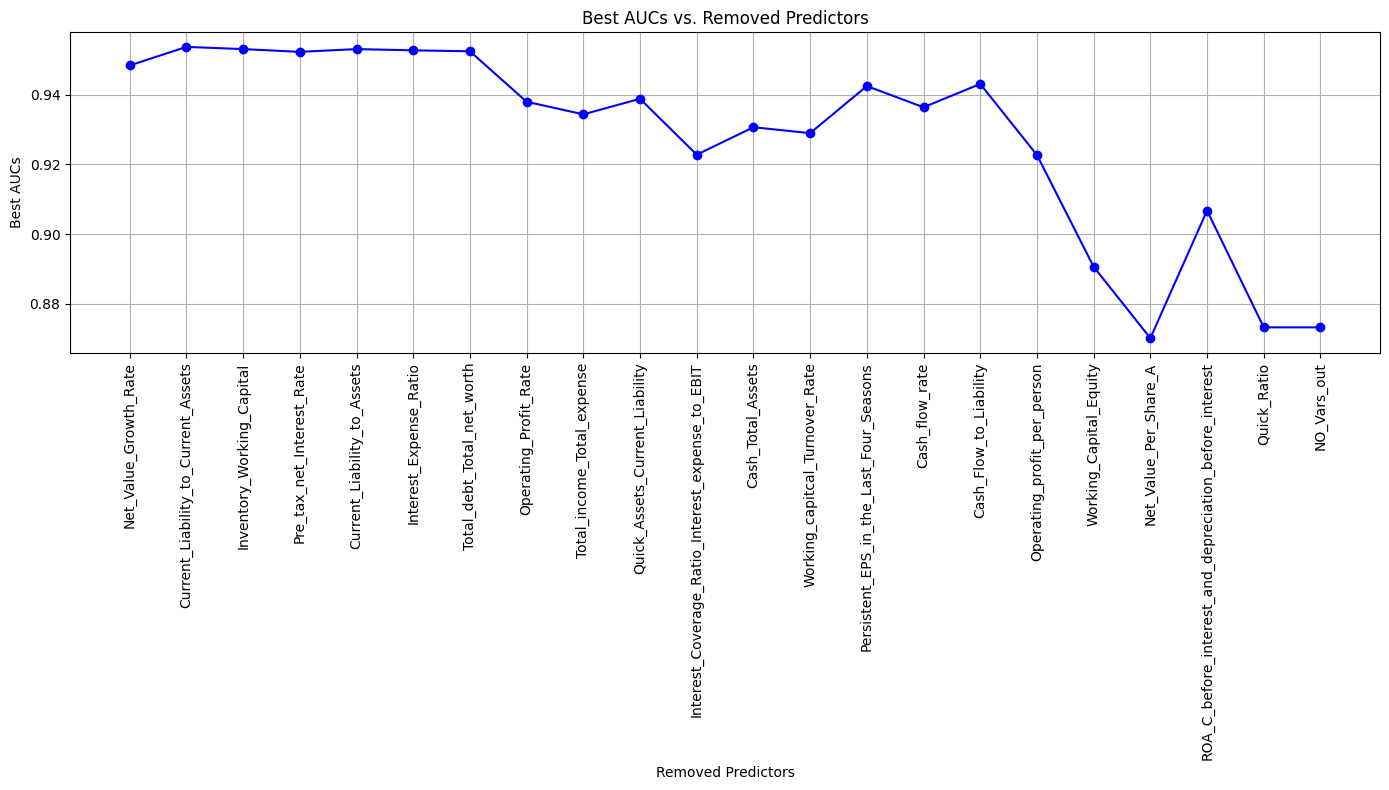

In [42]:
# Plotting
plt.figure(figsize=(14, 8))
plt.plot(removed_predictors, best_AUCs, marker='o', linestyle='-', color='b')
plt.xticks(rotation=90)
plt.xlabel('Removed Predictors')
plt.ylabel('Best AUCs')
plt.title('Best AUCs vs. Removed Predictors')
plt.grid(True)
plt.tight_layout()
# Display the plot
plt.show()

##### after Performance-based variable selection, we only have 10 variables left to enter the Model Fitting

In [43]:
df_final_features_train = df_X_train_preprocessed_WoE_RFE.drop(columns=['Net_Value_Growth_Rate',
                                                                         'Current_Liability_to_Current_Assets',
                                                                         'Inventory_Working_Capital',
                                                                         'Pre_tax_net_Interest_Rate',
                                                                         'Current_Liability_to_Assets',
                                                                         'Interest_Expense_Ratio',
                                                                         'ROA_C_before_interest_and_depreciation_before_interest',
                                                                         'Total_debt_Total_net_worth',
                                                                         'Persistent_EPS_in_the_Last_Four_Seasons',
                                                                         'Cash_Flow_to_Liability',
                                                                         'Quick_Assets_Current_Liability'])
                                                                           
df_final_features_train.shape

(5114, 10)

##### The final list of variables has 10 variables after comprehensive variable selection process

In [44]:
df_final_features_train.columns

Index(['Interest_Coverage_Ratio_Interest_expense_to_EBIT',
       'Total_income_Total_expense', 'Net_Value_Per_Share_A', 'Quick_Ratio',
       'Operating_Profit_Rate', 'Working_capitcal_Turnover_Rate',
       'Working_Capital_Equity', 'Operating_profit_per_person',
       'Cash_Total_Assets', 'Cash_flow_rate'],
      dtype='object')

# 3. Model Training & Fitting & Calibration

## 3.1 Random Forest Classifier with hyper-parameter tuning

In [45]:
rf = RandomForestClassifier(random_state=123, class_weight='balanced')

rf_param_grid = {
    'max_depth': np.arange(2, 16, 2),
    'n_estimators': np.arange(50, 600, 25),
    'min_samples_split' : [2, 3, 5, 7, 10, 12, 15],
    'min_samples_leaf' : [1, 2, 3, 5, 7, 10, 12] 
}

In [46]:
RF_randomized_roc_auc = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_grid, 
                                        n_iter=20, scoring='roc_auc', cv=10,
                                        random_state=123, n_jobs = -2)

In [47]:
RF_randomized_roc_auc.fit(df_final_features_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=123),
                   n_iter=20, n_jobs=-2,
                   param_distributions={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14]),
                                        'min_samples_leaf': [1, 2, 3, 5, 7, 10,
                                                             12],
                                        'min_samples_split': [2, 3, 5, 7, 10,
                                                              12, 15],
                                        'n_estimators': array([ 50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350,
       375, 400, 425, 450, 475, 500, 525, 550, 575])},
                   random_state=123, scoring='roc_auc')

In [48]:
print(RF_randomized_roc_auc.best_estimator_)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=12, n_estimators=225, random_state=123)


## 3.2 Calibrate Model with chosen methods and Cross-Validation   

In [49]:
calibrator = CalibratedClassifierCV(RF_randomized_roc_auc,method='sigmoid', cv=10)
calibrator

CalibratedClassifierCV(cv=10,
                       estimator=RandomizedSearchCV(cv=10,
                                                    estimator=RandomForestClassifier(class_weight='balanced',
                                                                                     random_state=123),
                                                    n_iter=20, n_jobs=-2,
                                                    param_distributions={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14]),
                                                                         'min_samples_leaf': [1,
                                                                                              2,
                                                                                              3,
                                                                                              5,
                                                                                              7,
                                                                                              10,
                                                                                              12],
                                                                         'min_samples_split': [2,
                                                                                               3,
                                                                                               5,
                                                                                               7,
                                                                                               10,
                                                                                               12,
                                                                                               15],
                                                                         'n_estimators': array([ 50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350,
       375, 400, 425, 450, 475, 500, 525, 550, 575])},
                                                    random_state=123,
                                                    scoring='roc_auc'))

In [50]:
calibrator.fit(df_final_features_train, y_train)

CalibratedClassifierCV(cv=10,
                       estimator=RandomizedSearchCV(cv=10,
                                                    estimator=RandomForestClassifier(class_weight='balanced',
                                                                                     random_state=123),
                                                    n_iter=20, n_jobs=-2,
                                                    param_distributions={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14]),
                                                                         'min_samples_leaf': [1,
                                                                                              2,
                                                                                              3,
                                                                                              5,
                                                                                              7,
                                                                                              10,
                                                                                              12],
                                                                         'min_samples_split': [2,
                                                                                               3,
                                                                                               5,
                                                                                               7,
                                                                                               10,
                                                                                               12,
                                                                                               15],
                                                                         'n_estimators': array([ 50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350,
       375, 400, 425, 450, 475, 500, 525, 550, 575])},
                                                    random_state=123,
                                                    scoring='roc_auc'))

In [51]:
y_pred_train_RF = calibrator.predict_proba(df_final_features_train)

In [52]:
y_pred_proba = y_pred_train_RF[:, 1]
y_pred_proba
fpr, tpr, _ = roc_curve(y_train, y_pred_proba)
roc_auc = auc(fpr, tpr)
roc_auc

0.9802188382103516

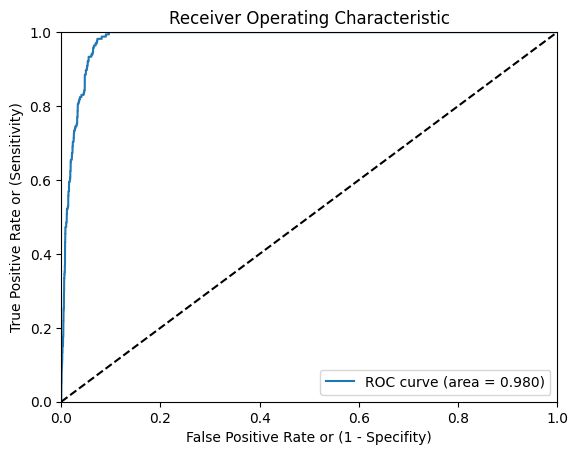

In [53]:
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# 4. Applying pre-processing data steps to Test Set

####  Applying the same data preperation steps to test set and predict the labels for test set

In [54]:
X_test_preprocessed = preprocessing.transform(X_test)
df_X_test_preprocessed = pd.DataFrame(X_test_preprocessed,columns=preprocessing.get_feature_names_out())

In [55]:
df_X_test_preprocessed.shape

(1705, 94)

In [56]:
df_X_test_preprocessed_corr = df_X_test_preprocessed.drop(columns=tr.features_to_drop_)
df_X_test_preprocessed_corr.shape

(1705, 75)

In [57]:
df_X_test_preprocessed_WoE = binning_process.transform(df_X_test_preprocessed_corr, metric="woe")

In [58]:
df_X_test_preprocessed_WoE = df_X_test_preprocessed_WoE[selected_filter_IV]

In [59]:
df_X_test_preprocessed_WoE.shape

(1705, 34)

In [60]:
df_X_test_preprocessed_WoE_RFE = rfe.transform(df_X_test_preprocessed_WoE)

In [61]:
df_X_test_preprocessed_WoE_RFE = pd.DataFrame(df_X_test_preprocessed_WoE_RFE, columns=selected_features)
df_X_test_preprocessed_WoE_RFE.shape

(1705, 21)

In [62]:
df_final_features_test = df_X_test_preprocessed_WoE_RFE.drop(columns=[   'Net_Value_Growth_Rate',
                                                                         'Current_Liability_to_Current_Assets',
                                                                         'Inventory_Working_Capital',
                                                                         'Pre_tax_net_Interest_Rate',
                                                                         'Current_Liability_to_Assets',
                                                                         'Interest_Expense_Ratio',
                                                                         'ROA_C_before_interest_and_depreciation_before_interest',
                                                                         'Total_debt_Total_net_worth',
                                                                         'Persistent_EPS_in_the_Last_Four_Seasons',
                                                                         'Cash_Flow_to_Liability',
                                                                         'Quick_Assets_Current_Liability'])

df_final_features_test.shape

(1705, 10)

In [63]:
y_pred_test_RF = calibrator.predict_proba(df_final_features_test)

In [64]:
y_pred_proba_test = y_pred_test_RF[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)
roc_auc

0.915823691460055

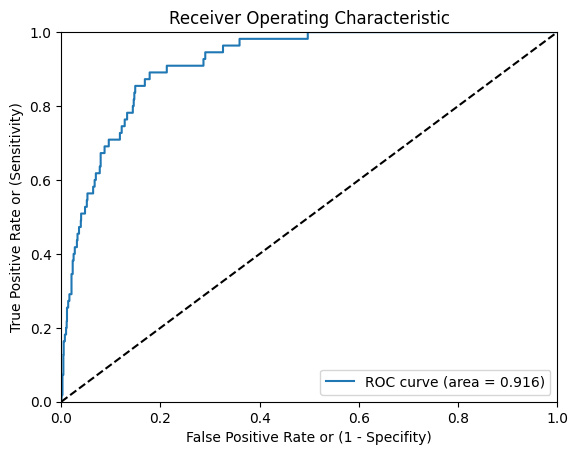

In [65]:
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

###### In summary, the final model with only 10 variables can achieve AUC-ROC = 92% on the Test Set

### Measure the quality of model with calibrate probabilities

##### a well-calibrated curve is essential to increase the confidence in the model and reliability of model quality

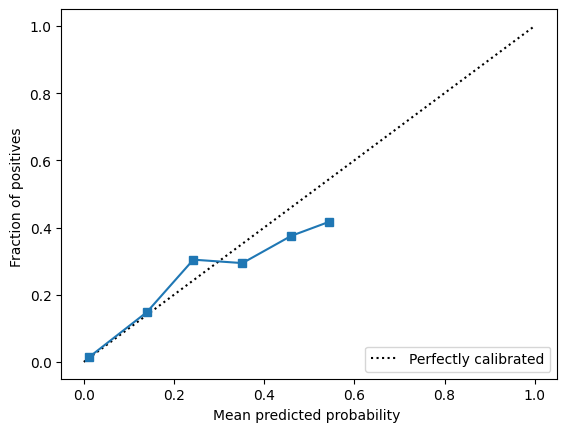

In [66]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba_test,n_bins=10)

disp = CalibrationDisplay(prob_true, prob_pred, y_pred_proba_test)
disp.plot()

In [72]:
y_pred_proba_uncalibrated = RF_randomized_roc_auc.predict_proba(df_final_features_test)
y_pred_test_RF_uncalibrated = y_pred_proba_uncalibrated[:, 1]

In [73]:
prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_test, y_pred_proba_test,n_bins=10)
prob_true_uncalibrated, prob_pred_uncalibrated = calibration_curve(y_test, y_pred_test_RF_uncalibrated, n_bins=10)

In [ ]:
disp_calibrated = CalibrationDisplay(prob_true_calibrated, prob_pred_calibrated, y_pred_proba_test)
disp_uncalibrated = CalibrationDisplay(prob_true_uncalibrated, prob_pred_uncalibrated, y_pred_proba_uncalibrated)

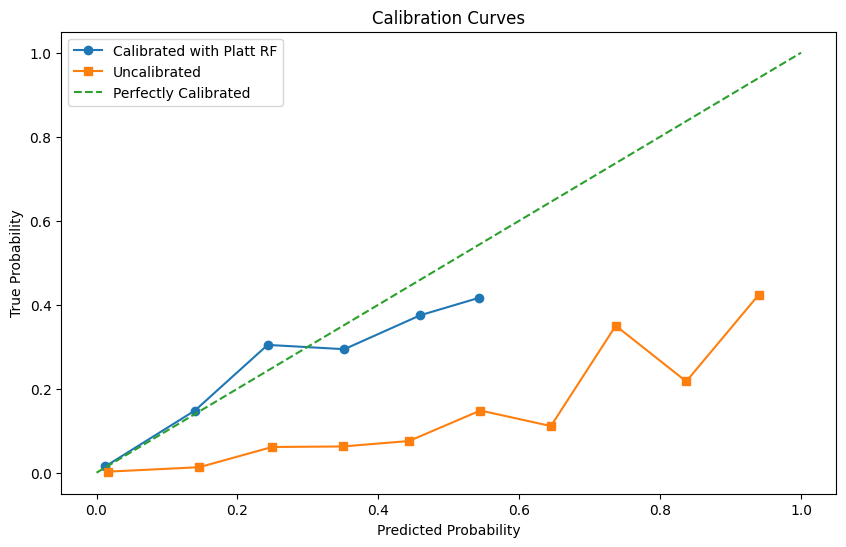

In [82]:
# Plot calibration curves
plt.figure(figsize=(10, 6))
plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='o', label='Calibrated with Platt RF')
plt.plot(prob_pred_uncalibrated, prob_true_uncalibrated, marker='s', label='Uncalibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')

plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curves')
plt.legend()
plt.show()

In [67]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)

##### Plot precision-recall curve

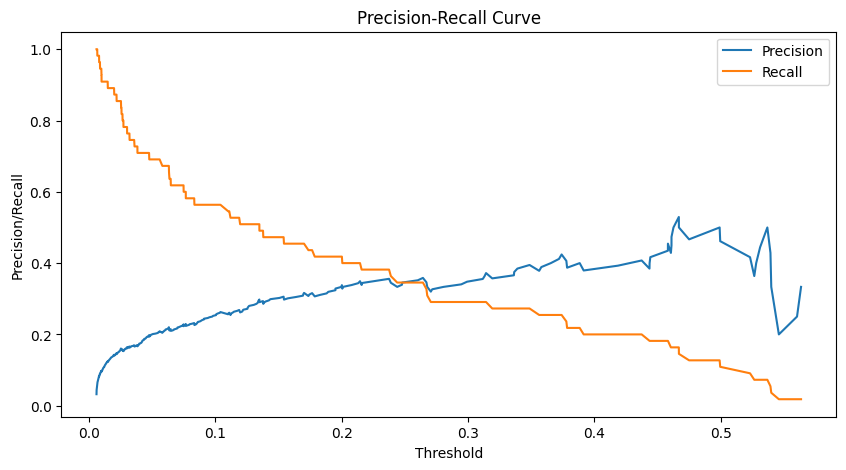

In [68]:

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

##### Find the optimal threshold

In [79]:
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

Optimal Threshold: 0.13480901674415655


#####  Calculate F1 score at the optimal threshold

In [81]:
y_pred_optimal = (y_pred_proba_test >= optimal_threshold).astype(int)
f1 = f1_score(y_test, y_pred_optimal)
print(f"F1 Score at Optimal Threshold: {f1}")

F1 Score at Optimal Threshold: 0.37583892617449666


In [70]:
auc_roc = roc_auc_score(y_test, y_pred_proba_test)
auc_roc

0.915823691460055

In [71]:
brier_score = brier_score_loss(y_test, y_pred_proba_test)
brier_score

0.026469574567623007